# DBSCAN Model
## By Steve Martinez
### Using DBSCAN library from sklearn

In [2]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset 
### More preprocessing needed before running DBSCAN
- dropped transactions with null credit card numbers
- ensure that all values in 'is_fraud" column are 1 or 0 (integers)

In [4]:
#load the dataset
data = pd.read_csv('Martinez_dataset.csv')

#drop records with null `cc_num`
data = data.dropna(subset=['cc_num'])

#ensure `is_fraud` only has 0 and 1 as values (int)
valid_values = ['0', '1', 0, 1]
data = data[data['is_fraud'].isin(valid_values)]
data['is_fraud'] = data['is_fraud'].astype(int)


C:\Users\steve\AppData\Local\Temp\ipykernel_72336\3156052640.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Martinez_dataset.csv')


## Create a function that runs DBSCAN on data
- takes in the transactions belonging to the same credit card number (same user)
- uses eclidean metric to find distance between lat, long, merch_lat, merch_long

In [6]:
#function for applying DBSCAN to all transactions belonging to each credit card holder
def apply_dbscan_per_cc(user_data):
    #lat/long and merchant lat/long will be used for clustering
    features = user_data[['lat', 'long', 'merch_lat', 'merch_long']].values
    
    #apply DBSCAN with Euclidean metric
    dbscan = DBSCAN(eps=0.4, min_samples=10, metric='euclidean')
    labels = dbscan.fit_predict(features)
    user_data['cluster'] = labels
    return user_data

## Implementing DBSCAN
- create new column for data to record the predicted fraud values
- group transactions by credit card number
- call DBSCAN method for each group of data
- finally, combine the results

In [8]:
#initialize all cluster values to -1 (noise/fraud)
data['cluster'] = -1  

#group transactions by credit card number
grouped_data = data.groupby('cc_num')
results = []

#run dbscan funtion for all credit card grouped transactions
for cc_num, cc_transactions in grouped_data:
    user_results = apply_dbscan_per_cc(cc_transactions)
    results.append(user_results)

# Combine processed data back together
final_data = pd.concat(results)

## Display the number of clusters formed and noise points

In [10]:
#count the number of noise and clusters
n_clusters = len(set(final_data['cluster'])) - (1 if -1 in final_data['cluster'].values else 0)
n_noise = (final_data['cluster'] == -1).sum()

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

#map values`cluster == -1` to fraud (1), others to non-fraud (0)
final_data['predicted_fraud'] = (final_data['cluster'] == -1).astype(int)

Number of clusters: 1
Number of noise points: 741


## Graph showing clusters of where transactions are located

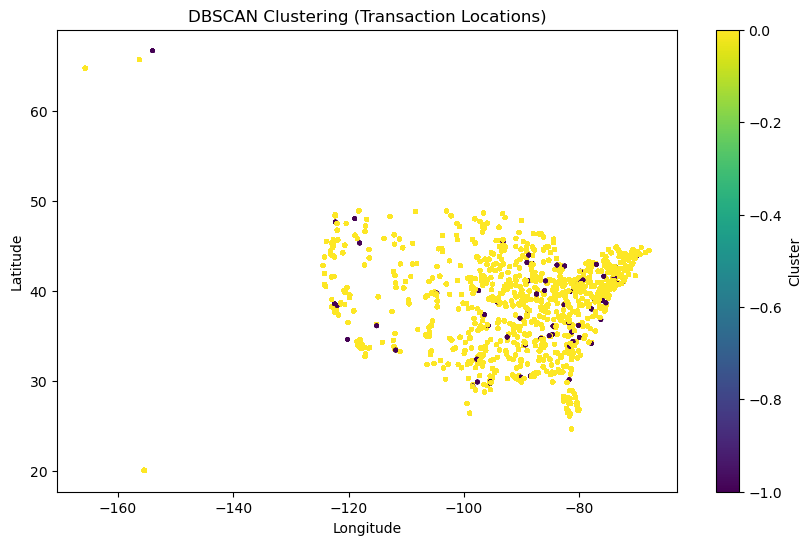

In [12]:
#plot DBSCAN clusters for dataset
plt.figure(figsize=(10, 6))
plt.scatter(final_data['long'], final_data['lat'], c=final_data['cluster'], cmap='viridis', s=5)
plt.title('DBSCAN Clustering (Transaction Locations)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Evaluation
## Confusion Matrix

Evaluation:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1289169
           1       1.00      0.10      0.18      7506

    accuracy                           0.99   1296675
   macro avg       1.00      0.55      0.59   1296675
weighted avg       0.99      0.99      0.99   1296675



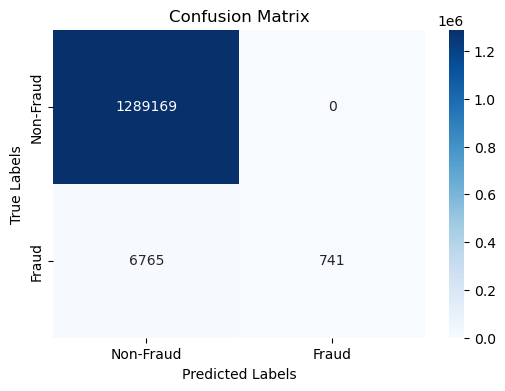

In [14]:
#use sklearn to calculate confusion matrix
cm = confusion_matrix(final_data['is_fraud'], final_data['predicted_fraud'])

#use sklearn to calculate classification report
print("Evaluation:")
print(classification_report(final_data['is_fraud'], final_data['predicted_fraud']))

#display graph of confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision Recall Curve

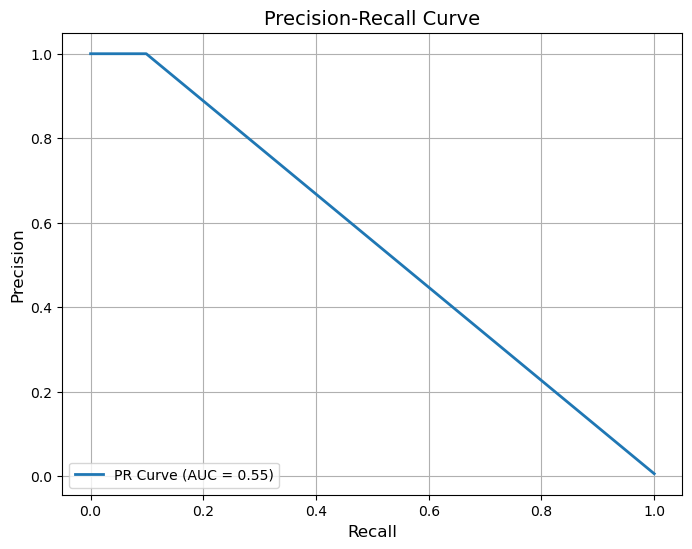

In [16]:
#get the true labels and predictions
y_true = final_data['is_fraud']  
y_pred = final_data['predicted_fraud'] 

#generate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#calculate the area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

#plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True)
plt.show()